# Multi-Qubit-Classifier - NN Encoding



Idea of the notebook:

Hybrid classical - quantum network:
* Input Data is encoded with a classical network
* Results are fed into a quantum network
* Measurement results are fed to a second classical network 

Trainable parameters in all three networks are trained via tensorflow

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

import cirq
import sympy
import numpy as np
import pandas as pd

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from cirq.contrib.svg import SVGCircuit

In [2]:
## See  issue PQC in the middle of network, contd. #267: https://github.com/tensorflow/quantum/issues/267
## Thanks to MichaelBroughton

class SplitBackpropQ(tf.keras.layers.Layer):

    def __init__(self, upstream_symbols, managed_symbols, managed_init_vals,
                 operators):
        """Create a layer that splits backprop between several variables.


        Args:
            upstream_symbols: Python iterable of symbols to bakcprop
                through this layer.
            managed_symbols: Python iterable of symbols to backprop
                into variables managed by this layer.
            managed_init_vals: Python iterable of initial values
                for managed_symbols.
            operators: Python iterable of operators to use for expectation.

        """
        super().__init__(SplitBackpropQ)
        self.all_symbols = upstream_symbols + managed_symbols
        self.upstream_symbols = upstream_symbols
        self.managed_symbols = managed_symbols
        self.managed_init = managed_init_vals
        self.ops = operators

    def build(self, input_shape):
        self.managed_weights = self.add_weight(
            shape=(1, len(self.managed_symbols)),
            initializer=tf.constant_initializer(self.managed_init))

    def call(self, inputs):
        # inputs are: circuit tensor, upstream values
        upstream_shape = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_weights = tf.tile(self.managed_weights, [upstream_shape, 1])
        joined_params = tf.concat([inputs[1], tiled_up_weights], 1)
        return tfq.layers.Expectation()(inputs[0],
                                        operators=ops,
                                        symbol_names=self.all_symbols,
                                        symbol_values=joined_params)

In [3]:
## Fix parameters of the quantum network:
n_layer=3
n_qubits=3

### Generating data

Generate data to be classified:
- Linear (`linear`)
- Circle (`circle`)
- Moons (`moons`)
- 4 Circles (`xor`)

In [4]:
def generate_data(dataset="linear"):
    np.random.seed(seed=123)
    n = 900

    if dataset=="linear":
        data = np.random.rand(n, 2)

        labels=[]

        for p in range(0,n):
            if data[p,0] <= 0.5:
                label=[1,0]
            else:
                label=[0,1]
            labels.append(label)
        labels=np.array(labels)


        # plot the line y = x
        xs = np.linspace(0, 1, 100)
        ys = 0.5 * np.ones_like(xs)
        plt.plot(ys, xs, '--k')

        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points in Unit Square", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()
        
        
    elif dataset=="circle":
        data = np.random.rand(n, 2)

        labels=[]

        for p in range(0,n):
            if (data[p,0]-0.5)**2 + (data[p,1]-0.5)**2 <= 0.1:
                label=[1,0]
            else:
                label=[0,1]
            labels.append(label)
        labels=np.array(labels)

        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points in Unit Circle", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()    

    elif dataset=="circle_2":
        data, label = make_circles(noise=0.1, factor=0.3, random_state=1,n_samples=n)    

        labels=[]

        for j in range(0,len(label)):
            if label[j]==0:
                tmp=[1,0]
            else:
                tmp=[0,1]
            labels.append(tmp)
        labels=np.array(labels)


        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()



    elif dataset=="moons":
        data = np.random.rand(n, 2)


        data,label = make_moons(n_samples=n,random_state=5,noise=0.04)

        labels=[]

        for j in range(0,len(label)):
            if label[j]==0:
                tmp=[1,0]
            else:
                tmp=[0,1]
            labels.append(tmp)
        labels=np.array(labels)


        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

    # title and axis lables
        plt.title("Data Points", fontweight="bold", fontsize=16)

    # put on a grid and show the plot
        plt.grid()
        plt.show()

    elif dataset=="xor":
        #centers = np.array([[0,0],[0,1],[1,0],[1,1]])
        centers = np.array([[0.25,0.25],[0.75,0.25],[0.25,0.75],[0.75,0.75]])      
        label = np.array([0,1,1,0])
        data = np.array([]).reshape(-1,3)
        for center, label in zip(centers,label):
            points = np.random.normal(loc=center,scale=0.09,size=(n//4,2))
            points_labels = np.hstack((points,label*np.ones(n//4).reshape((-1, 1))))
            data = np.vstack((data,points_labels))
        erg=(data[:,[0,1]],data[:,2])
        data=erg[0]
        label=erg[1]

        labels=[]
        for j in range(0,len(label)):
            if label[j]==0:
                tmp=[0,1]
            else:
                tmp=[1,0]
            labels.append(tmp)
        labels=np.array(labels)

        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points XOR", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()
    else:
        print("Data not implemented :-(")

    data_train,data_test,y_train,y_test= train_test_split(data,labels,stratify=labels,test_size=0.1,random_state=13)              
    return data_train, data_test, y_train, y_test

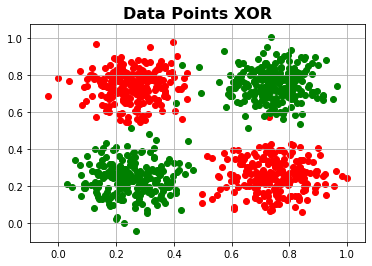

In [5]:
# Fix dataset:

dta="xor"
data_train,data_test,y_train,y_test=generate_data(dataset=dta)

In [6]:
n=data_train.shape[0]
n_test=data_test.shape[0]

### Qubit Encoding



In [7]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [8]:
## Definition of the quantum network
## I guess it could be done more elegantly :-) 

qubits = [cirq.GridQubit(x, y) for x in range(1) for y in range(n_qubits)]

control_params = sympy.symbols('theta:{}(0:{})'.format(n_qubits,3))
control_params1 = sympy.symbols('phi:{}(0:{})'.format(n_qubits,3*n_layer))

q_model = cirq.Circuit()

for i in range(0,n_qubits):
    q_model.append(cirq.ry(control_params[3*i])(qubits[i]))
    q_model.append(cirq.rz(control_params[3*i+1])(qubits[i]))
    q_model.append(cirq.ry(control_params[3*i+2])(qubits[i]))
if n_qubits==2:
    q_model.append(cirq.CX(qubits[0],qubits[1]))
if n_qubits==3:
    q_model.append(cirq.CX(qubits[0],qubits[1]))
    q_model.append(cirq.CX(qubits[1],qubits[2]))
if n_qubits==4:
    q_model.append(cirq.CX(qubits[3],qubits[0]))
    q_model.append(cirq.CX(qubits[2],qubits[3]))    
    q_model.append(cirq.CX(qubits[1],qubits[2])) 
    q_model.append(cirq.CX(qubits[0],qubits[1])) 
    
for j in range(0,n_layer):
    for i in range(0,n_qubits):
        q_model.append(cirq.ry(control_params1[3*i+3*j*n_qubits])(qubits[i]))
        q_model.append(cirq.rz(control_params1[3*i+1+3*j*n_qubits])(qubits[i]))
        q_model.append(cirq.ry(control_params1[3*i+2+3*j*n_qubits])(qubits[i]))
    if n_qubits==2:
        q_model.append(cirq.CX(qubits[0],qubits[1]))
    if n_qubits==3:
        q_model.append(cirq.CX(qubits[0],qubits[1]))
        q_model.append(cirq.CX(qubits[1],qubits[2]))
    if n_qubits==4:
        q_model.append(cirq.CX(qubits[3],qubits[0]))
        q_model.append(cirq.CX(qubits[2],qubits[3]))    
        q_model.append(cirq.CX(qubits[1],qubits[2])) 
        q_model.append(cirq.CX(qubits[0],qubits[1])) 

q_model

(0, 0): ───Ry(theta00)───Rz(theta01)───Ry(theta02)───@───Ry(phi00)───Rz(phi01)───Ry(phi02)───────────────@───Ry(phi10)───Rz(phi11)───Ry(phi12)───────────────@───Ry(phi20)───Rz(phi21)───Ry(phi22)───────────────@───────
                                                     │                                                   │                                                   │                                                   │
(0, 1): ───Ry(theta10)───Rz(theta11)───Ry(theta12)───X───@───────────Ry(phi03)───Rz(phi04)───Ry(phi05)───X───@───────────Ry(phi13)───Rz(phi14)───Ry(phi15)───X───@───────────Ry(phi23)───Rz(phi24)───Ry(phi25)───X───@───
                                                         │                                                   │                                                   │                                                   │
(0, 2): ───Ry(theta20)───Rz(theta21)───Ry(theta22)───────X───────────Ry(phi06)───Rz(phi07)───Ry(phi08)───────X───────────Ry(phi16)───Rz(phi17)───Ry(phi18)───────X───────────Ry(phi26)───Rz(phi27)───Ry(phi28)───────X───

In [9]:
len(control_params)

9

In [10]:
np.random.seed(seed=42)
int_values=np.random.rand((len(control_params1)))*np.pi
int_values

array([1.17665249, 2.98675708, 2.29962679, 1.8807411 , 0.49014701,
       0.49007124, 0.18247505, 2.72117262, 1.8884585 , 2.22447561,
       0.0646681 , 3.04706167, 2.61519568, 0.66708299, 0.57121998,
       0.57618226, 0.9558052 , 1.64857095, 1.3569953 , 0.91492333,
       1.92219256, 0.43823289, 0.91779948, 1.15095968, 1.43278611,
       2.46670303, 0.62729369])

In [11]:
## Measurement part of the network:

if n_qubits==1:
    ops = [cirq.Z(qubits[0])] 
if n_qubits==2:
    ops = [cirq.Z(qubits[0]), cirq.Z(qubits[1])] 
if n_qubits==3:
    ops = [cirq.Z(qubits[0]), cirq.Z(qubits[1]),cirq.Z(qubits[2])] 
if n_qubits==4:
    ops = [cirq.Z(qubits[0]), cirq.Z(qubits[1]),cirq.Z(qubits[2]),cirq.Z(qubits[3])]     

In [12]:
data_input = tf.keras.Input(shape=(data_train.shape[1],), dtype=tf.dtypes.float32)

#Use a classical NN to transform the data
encod_1 = tf.keras.layers.Dense(10, activation=tf.keras.activations.relu)(data_input)
encod_2 = tf.keras.layers.Dense(len(control_params), activation=tf.keras.activations.sigmoid)(encod_1)

# This is needed because of Note here:
# https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/Expectation
unused = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

#expectation = SplitBackpropQ(['alpha','beta', 'gamma'], ['eta','theta', 'psi'], [np.pi / 2, np.pi/2, np.pi/2 ],
#                             ops)([unused, encod_2])
expectation = SplitBackpropQ(control_params, control_params1, int_values,
                             ops)([unused, encod_2])

classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
classifier_output = classifier(expectation)

model = tf.keras.Model(inputs=[unused, data_input], outputs=classifier_output)


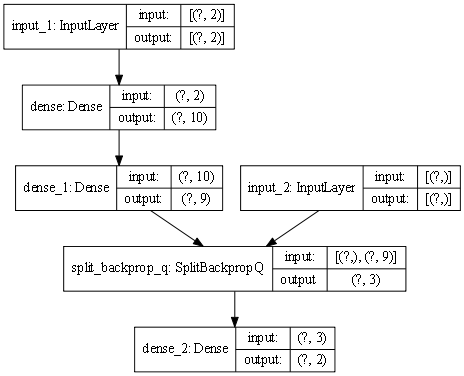

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [14]:
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#              loss=tf.keras.losses.mean_squared_error)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
loss=tf.keras.losses.BinaryCrossentropy(),metrics=METRICS)
              
#model.compile(optimizer='Adam', loss='mse')
# Now we can see 37 parameters. Two of which belong to "SplitBackpropQ"
# since we told it above on L81 that we want it to manage ["beta", "gamma"]
#print(model.trainable_variables)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 9)            99          dense[0][0]                      
______________________________________________________________________________________________

In [15]:
history=model.fit([tfq.convert_to_tensor([q_model for _ in range(n)]), data_train],
          y_train, batch_size=10, validation_split = 0.1,
          epochs=10,verbose=1)

Train on 729 samples, validate on 81 samples
Epoch 1/10
729/729 [==============================] - 18s 24ms/sample - loss: 0.6732 - tp: 448.0000 - fp: 281.0000 - tn: 448.0000 - fn: 281.0000 - accuracy: 0.6145 - precision: 0.6145 - recall: 0.6145 - auc: 0.6592 - val_loss: 0.6103 - val_tp: 55.0000 - val_fp: 26.0000 - val_tn: 55.0000 - val_fn: 26.0000 - val_accuracy: 0.6790 - val_precision: 0.6790 - val_recall: 0.6790 - val_auc: 0.8387
Epoch 2/10
729/729 [==============================] - 10s 14ms/sample - loss: 0.5057 - tp: 651.0000 - fp: 78.0000 - tn: 651.0000 - fn: 78.0000 - accuracy: 0.8930 - precision: 0.8930 - recall: 0.8930 - auc: 0.9546 - val_loss: 0.3617 - val_tp: 74.0000 - val_fp: 7.0000 - val_tn: 74.0000 - val_fn: 7.0000 - val_accuracy: 0.9136 - val_precision: 0.9136 - val_recall: 0.9136 - val_auc: 0.9775
Epoch 3/10
729/729 [==============================] - 11s 14ms/sample - loss: 0.2261 - tp: 698.0000 - fp: 31.0000 - tn: 698.0000 - fn: 31.0000 - accuracy: 0.9575 - precision: 

## Results:

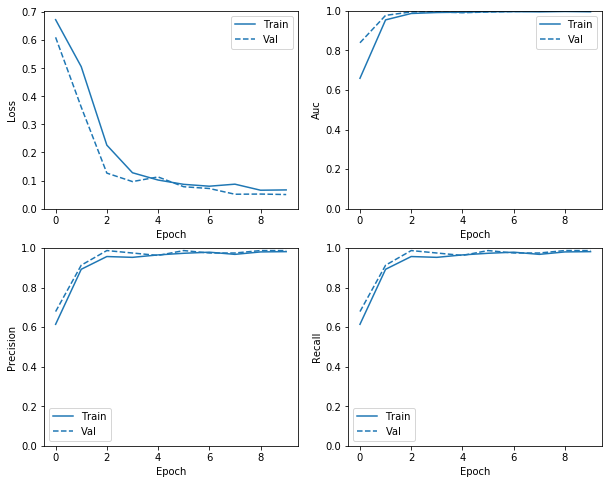

In [16]:
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(history)

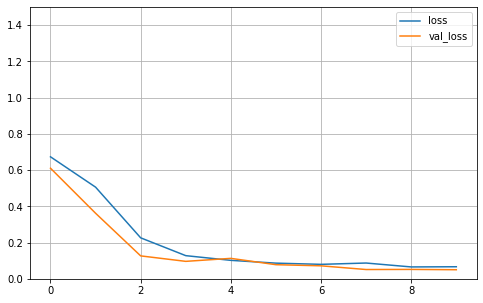

In [17]:
import pandas as pd
pd.DataFrame(history.history)[["loss","val_loss"]].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 1.5) # set the vertical range to [0-1]
plt.show()

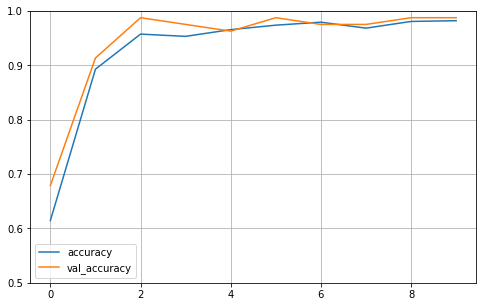

In [18]:
import pandas as pd
pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.5, 1) # set the vertical range to [0-1]
plt.show()

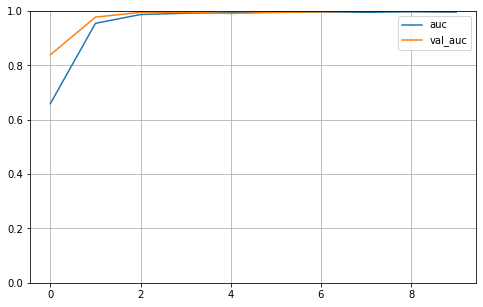

In [19]:
import pandas as pd
pd.DataFrame(history.history)[["auc","val_auc"]].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0., 1) # set the vertical range to [0-1]
plt.show()

### Predictions

Calculate predictions on the whole dataset.



In [20]:
prob_train = model.predict([tfq.convert_to_tensor([q_model for _ in range(n)]), data_train], batch_size=32)
prob_test =  model.predict([tfq.convert_to_tensor([q_model for _ in range(n_test)]), data_test], batch_size=32)

prob_tr=prob_train[:,0]
prob_te=prob_test[:,0]

y_tr=y_train[:,0]
y_te=y_test[:,0]


In [21]:
from scipy.optimize import minimize
def max_acc(x, a,b): 
    
    temp=[]
    for i in range(0,len(b)):
        if a[i]<x:
            temp.append(0)
        else:
            temp.append(1)
    return -accuracy_score(temp,b)

#obj=-max_acc(prob_tr_nn,y_tr,0.4)
out = minimize(fun=max_acc , x0=0.9, args=(prob_tr,y_tr), method="BFGS")
tr=out.x[0]
print(out)


      fun: -0.9567901234567902
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.9])


In [22]:
prog_tr=(prob_tr>tr)
prog_te=prob_te>tr

prog_train=prob_train>tr
prog_test=prob_test>tr

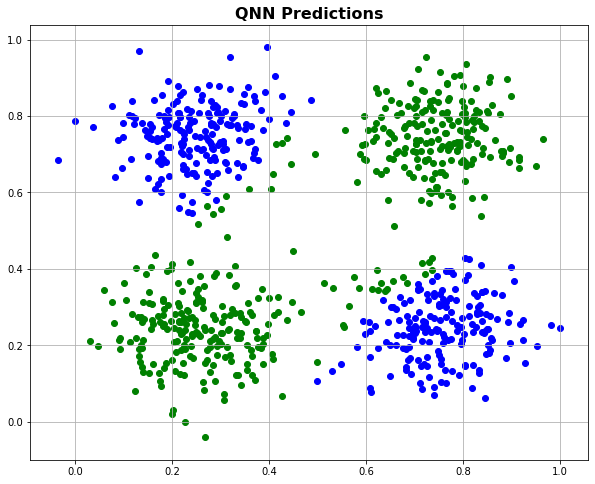

In [23]:
# compute statistics of the QNN

# plot the points, line y = x, and prediction
#plt.plot(ys, xs, '--k')
if dta != "finance":
    for i in range(len(prob_train)):
        if prog_tr[i] == 0:
            ckey = 'g'
        else:
            ckey = 'b'
        plt.scatter(data_train[i, 0], data_train[i, 1], color=ckey)
    plt.grid()
    plt.title("QNN Predictions", fontsize=16, fontweight="bold")
    plt.show()

In [24]:
print(accuracy_score(y_tr,prog_tr))
print(classification_report(y_train,prog_train))

0.9567901234567902
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       405
           1       0.99      0.95      0.97       405

   micro avg       0.99      0.93      0.96       810
   macro avg       0.99      0.93      0.96       810
weighted avg       0.99      0.93      0.96       810
 samples avg       0.93      0.93      0.93       810



C:\Users\ghell\Anaconda3\envs\TFQuantum\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
results = model.evaluate([tfq.convert_to_tensor([q_model for _ in range(n)]), data_train], y_train,
                                  batch_size=20, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()


loss :  0.04884545713732088
tp :  798.0
fp :  12.0
tn :  798.0
fn :  12.0
accuracy :  0.9851852
precision :  0.9851852
recall :  0.9851852
auc :  0.9983919



True Negatives:  403
False Positives:  2
False Negatives:  33
True Positives):  372
Total Positives:  405


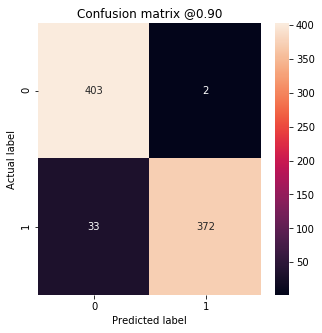

In [26]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives): ', cm[1][1])
  print('Total Positives: ', np.sum(cm[1]))

plot_cm(np.array(y_tr), np.array(prog_tr),tr)


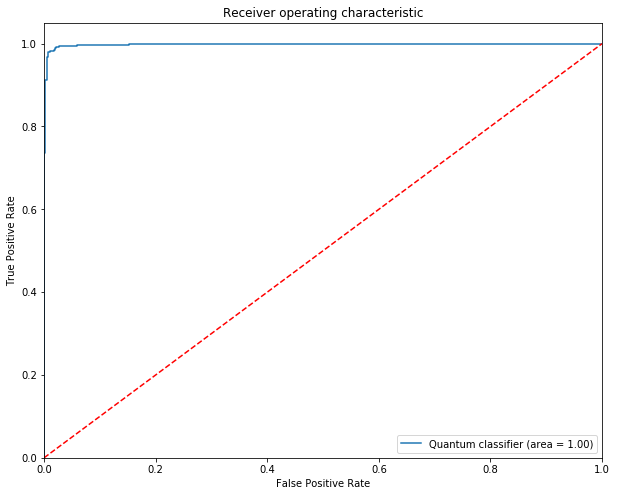

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_tr, prob_tr)
fpr, tpr, thresholds = roc_curve(y_tr, prob_tr)
plt.figure()
plt.plot(fpr, tpr, label='Quantum classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
results = model.evaluate([tfq.convert_to_tensor([q_model for _ in range(n_test)]), data_test], y_test,
                                  batch_size=20, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()


loss :  0.08273479621857405
tp :  87.0
fp :  3.0
tn :  87.0
fn :  3.0
accuracy :  0.96666664
precision :  0.96666664
recall :  0.96666664
auc :  0.9967901



True Negatives:  45
False Positives:  0
False Negatives:  5
True Positives):  40
Total Positives:  45


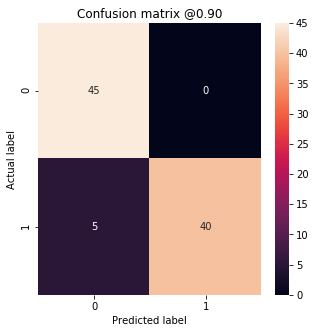

In [29]:
plot_cm(np.array(y_te), np.array(prog_te),tr)



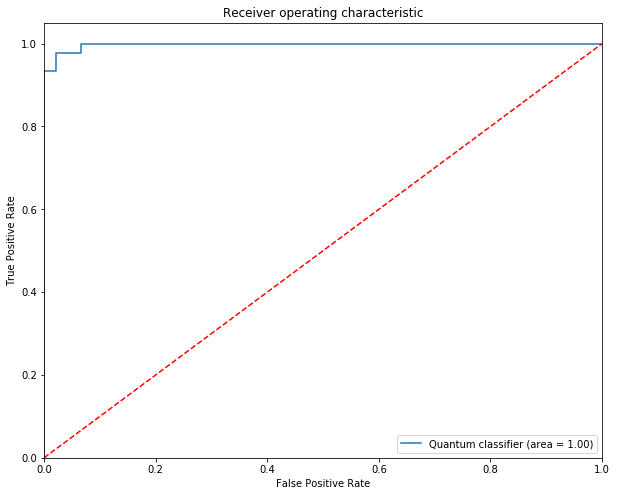

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_te, prob_te)
fpr, tpr, thresholds = roc_curve(y_te, prob_te)
plt.figure()
plt.plot(fpr, tpr, label='Quantum classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()